# The double integrator example with control loss over $\mathbb{R}⁻$

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min T, \\[0.5em]
        \dot{x}_1(t) = x_2(t) \\
        \dot{x}_2(t) =\mathbb{1}_{\mathbb{R}⁻}(x_1(t))\lambda + (1 - \mathbb{1}_{\mathbb{R}⁻}x_1(t))  u(t),  \\[0.5em]
        \lambda,u(t) \in [-1, 1], \\[0.5em]
        x(0) = x_0,\quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$

In [1]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirectSolution
    t; x1; x2; x3; p1; p2 ; u # x3 denotes the extended state i.e. λ
end

In [3]:
# Parameters
t0  = 0.    # initial time
x1f = 0.    # Final position
x2f = 0.
M   = 1.0;  # control bound

In [14]:
function  G(x) # Heaviside regularization 
    n = 10. 
    if -1/(2*n) < x < 1/(2*n) 
        return 1. - 3*abs2(n*x +0.5) + 2*abs2(n*x +0.5)*(n*x +0.5)
    elseif x ≤ -1/(2*n) 
        return 1.
    else x ≥ 1/(2*n) 
        return 0.    
    end
end;

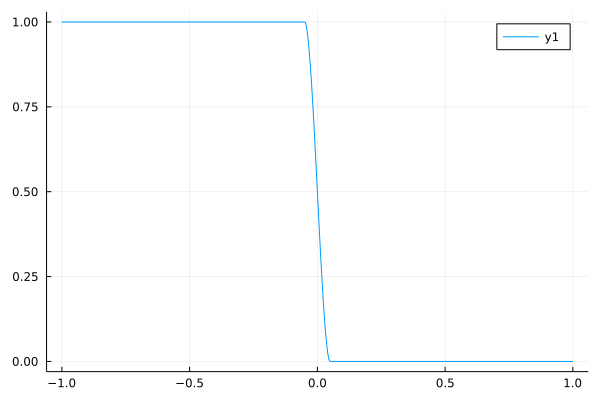

In [15]:
plot(G, -1, 1)

In [10]:
function DI(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)

    # register G function with 1 argument
    register(sys, :G, 1, G; autodiff = true)
    
    N  = nsteps     # Grid size

    @variables(sys, begin
        x1[1:N+1]    # x1
        x2[1:N+1]    # x2
        x3[1:N+1]    ##### x3=λ #####
        -M ≤ u[i=1:N+1] ≤ M # Control
        0. ≤ Δt ≤ 1. # contraints may be "superflues"
    end)

    # Objective
    @objective(sys, Min, Δt)

    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1] - x0[1] == 0
        con_x20, x2[1] - x0[2] == 0
        con_x30, -M ≤ x3[1] ≤ M     # parameter lambda constraint
        con_x1f, x1[N+1] - x1f == 0
        con_x2f, x2[N+1] - x2f == 0
        con_x3f, -M ≤ x3[N+1] ≤ M   # parameter lambda constraint
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], x3[j]*G(x1[j]) + (1. - G(x1[j]))*u[j]) # regularized dynamics
    @NLexpression(sys, dx3[j = 1:N+1], 0.) # augmented dynamics
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N], x3[j+1] == x3[j]
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    x3 = value.(x3)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
    
    px10 = dual(con_x10)
    px20 = dual(con_x20)
    px1f = dual(con_x1f)
    px2f = dual(con_x2f)

    if(px10*dual(con_dx1[1])<0); px10 = -px10; end
    if(px20*dual(con_dx2[1])<0); px20 = -px20; end
    if(px1f*dual(con_dx1[N])<0); px1f = -px1f; end
    if(px2f*dual(con_dx2[N])<0); px2f = -px2f; end

   # H = px1 * x2 + px2 * u > 0, according to Pontryagin Maximum Principle convention
    if (px10 * x2[1] + px20 * u[1] < 0) 
        sign = -1.0 # switch sign of dual variables
    else
        sign =  1.0
    end

     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2; px1f]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2; px2f]; # We add the multiplier from the limit conditions

     p1 = sign * [px10; px1[1:N-1]; px1f]; # We add the multiplier from the limit conditions
     p2 = sign * [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions
   
    return DirectSolution(t, x1, x2, x3, p1, p2, u)

end;

In [11]:
# Solving
x0_ref    = [-1.; 0.; ]
direct_sol= DI(x0_ref);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3204
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:     6800

Total number of variables............................:      805
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      604
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-03 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00

In [12]:
direct_sol.x3[1]

0.3996145979875523

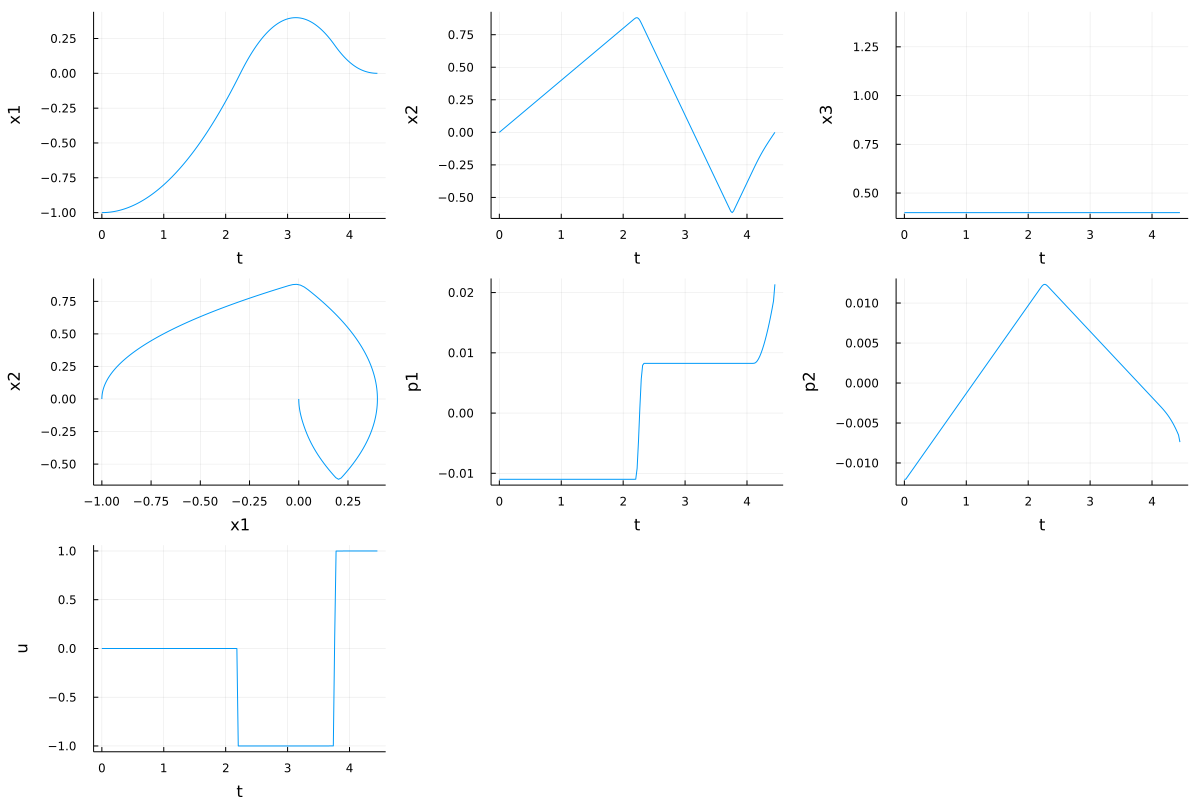

In [13]:
# Plots
t  = direct_sol.t
x1 = direct_sol.x1
x2 = direct_sol.x2
x3 = direct_sol.x3
u  = direct_sol.u
p1 = direct_sol.p1
p2 = direct_sol.p2

x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
x3_plot   = plot(t, x3,  xlabel = "t", ylabel = "x3",  legend = false)
p1_plot   = plot(t, p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t, p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot,x3_plot, x1x2_plot, p1_plot, p2_plot, u_plot, layout = (3,3), size=(1200,800), left_margin=5mm)